In [1]:
# Import the random library for generating random numbers (used for augmentations or shuffling).
import random

# Import PyTorch for building and training deep learning models.
import torch

# Import NumPy for numerical operations and working with arrays.
import numpy as np

# Import os for interacting with the file system (e.g., reading files or directories).
import os

# Import OpenCV (cv2) for image processing (e.g., reading images, applying filters).
import cv2

# Import Matplotlib for visualizing data, such as showing images or plots.
import matplotlib.pyplot as plt

# Import prebuilt deep learning models and related utilities from torchvision.
from torchvision import models

# Import PyTorch's neural network module for defining and using neural networks.
import torch.nn as nn

# Import tools to work with datasets and data loaders (used to feed data into models during training/testing).
from torch.utils.data import DataLoader, Dataset

# Import functions to calculate metrics like accuracy and confusion matrix (from sklearn).
from sklearn.metrics import accuracy_score, confusion_matrix

# Import a function to split data into training and testing sets.
from sklearn.model_selection import train_test_split

# Import pre-trained weights for ResNet-50 (a popular deep learning model for image classification).
from torchvision.models import ResNet50_Weights

# Import a function to calculate class weights (useful for handling imbalanced datasets).
from sklearn.utils.class_weight import compute_class_weight

# Import transformations (e.g., resizing, normalizing, and augmenting images) from torchvision.
import torchvision.transforms as transforms

# Import optimizers (used to adjust model weights during training).
import torch.optim as optim

# Check if a GPU is available. If yes, use it; otherwise, use the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the device being used (either GPU or CPU).
print(f"Using device: {device}")


Using device: cuda:0


In [2]:
# Dataset Class
class BananaDiseaseDataset(Dataset):  # Defines a custom dataset class inheriting from PyTorch's Dataset class.
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # Stores the file paths of all images in the dataset.
        self.labels = labels  # Stores the labels corresponding to each image.
        self.transform = transform  # Stores any transformations (e.g., resizing, normalization) to be applied.

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.image_paths)  # The length is simply the size of the image paths list.

    def __getitem__(self, idx):  # Retrieves an image and its label by index.
        image = cv2.imread(self.image_paths[idx])  # Reads the image at the given index using OpenCV.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converts the image from BGR to RGB color format.

        # CLAHE for contrast enhancement applied to luminance channel only
        image = self.apply_clahe(image)  # Calls the apply_clahe method to enhance the image contrast.

        if self.transform:  # Checks if transformations are specified.
            image = self.transform(image)  # Applies the specified transformations (e.g., resizing, normalization).

        label = self.labels[idx]  # Gets the label for the corresponding image index.
        return image, label  # Returns the processed image and its label as a tuple.

    def apply_clahe(self, image):  # Enhances the image contrast using CLAHE.
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)  # Converts the RGB image to Lab color space.
        l, a, b = cv2.split(lab)  # Splits the Lab image into L (luminance), A, and B channels.
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Creates a CLAHE object with specified parameters.
        cl = clahe.apply(l)  # Applies CLAHE to the luminance channel to enhance contrast.
        limg = cv2.merge((cl, a, b))  # Merges the enhanced L channel back with the A and B channels.
        return cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)  # Converts the Lab image back to RGB color space.


In [5]:
# Transforms
train_transform = transforms.Compose([  # Combines multiple transformations into a pipeline for training data.
    transforms.ToPILImage(),  # Converts a NumPy array image to a PIL image for further transformations.
    transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally with a 50% chance to simulate different orientations.
    transforms.RandomRotation(20),  # Randomly rotates the image within ±20 degrees to make the model robust to rotations.
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Randomly alters brightness, contrast, saturation, and hue for data augmentation.
    transforms.Resize((224, 224)),  # Resizes the image to 224x224 pixels, the input size required by most pretrained models.
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor and scales pixel values to the range [0, 1].
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizes the image with mean and standard deviation values for ImageNet datasets.
                         std=[0.229, 0.224, 0.225]),  # This ensures compatibility with pretrained models like ResNet.
])

val_transform = transforms.Compose([  # Combines transformations for validation data (simpler as no augmentation is applied).
    transforms.ToPILImage(),  # Converts the image to a PIL image for transformations.
    transforms.Resize((224, 224)),  # Resizes the image to 224x224 pixels to match the input size of the model.
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor and scales pixel values to the range [0, 1].
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalizes the image using the same mean as training data for consistency.
                         std=[0.229, 0.224, 0.225]),  # Uses the standard deviation values for pretrained ImageNet models.
])


In [7]:
# Model Class
class CNNModel(nn.Module):  # Defines a custom neural network model class that inherits from PyTorch's nn.Module.
    def __init__(self, num_classes):  # Initializes the model, with `num_classes` specifying the number of output classes.
        super(CNNModel, self).__init__()  # Calls the initializer of the parent class `nn.Module`.

        # Loads a pretrained ResNet-50 model with weights from ImageNet.
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Freeze earlier layers to prevent their weights from being updated during training.
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze layers `layer3` and `layer4` to allow their weights to be updated during training.
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected layer (`fc`) in ResNet-50 to adapt it for the current classification task.
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # First fully connected layer, reduces feature dimensions to 512.
            nn.ReLU(),  # Applies the ReLU activation function to introduce non-linearity.
            nn.Dropout(p=0.5),  # Adds dropout with a probability of 0.5 to prevent overfitting.
            nn.Linear(512, num_classes)  # Final fully connected layer outputs predictions for `num_classes`.
        )

    def forward(self, x):  # Defines the forward pass of the model.
        return self.model(x)  # Passes the input `x` through the modified ResNet-50 model and returns the output.


In [9]:
# Training Function with Average Confusion Matrix Calculation
def train_with_honey_badger(model, train_loader, val_loader, class_weights, num_epochs=25, lr=1e-3):
    # Define the loss function as CrossEntropyLoss, weighted by class_weights to handle class imbalance
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Use the AdamW optimizer for training, which includes weight decay to reduce overfitting
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Define a learning rate scheduler that reduces the learning rate if validation accuracy plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    best_accuracy = 0.0  # Variable to store the best validation accuracy during training
    all_cm = []  # List to store confusion matrices for each epoch

    for epoch in range(num_epochs):  # Loop through the specified number of epochs
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize cumulative loss for the epoch

        for inputs, labels in train_loader:  # Iterate through the training dataset
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU (if available)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass: compute model outputs
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters using gradients

            running_loss += loss.item()  # Accumulate loss for this batch

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Learning Rate: {current_lr:.6f}")

        # Validation step to evaluate the model on the validation set
        val_accuracy, epoch_cm = validate_model(model, val_loader)

        # Append the confusion matrix of this epoch to the list
        all_cm.append(epoch_cm)

        # Print validation accuracy and confusion matrix for the current epoch
        print(f"Validation Accuracy for Epoch {epoch+1}: {val_accuracy * 100:.2f}%")
        print("Confusion Matrix for Epoch", epoch + 1)
        print(epoch_cm)  # Display confusion matrix for the epoch

        # Adjust learning rate based on validation accuracy
        scheduler.step(val_accuracy)

        # Save the model if it achieves the best validation accuracy so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "BDD_CNN_CLAHE_HBOA_Ci6.pth")  # Save model's state to a file
            print(f"Best model saved with Validation Accuracy: {best_accuracy * 100:.2f}%")

    # Compute the average confusion matrix over all epochs
    avg_cm = np.mean(np.array(all_cm), axis=0)
    print("Average Confusion Matrix across all epochs:")
    print(avg_cm)  # Display the average confusion matrix

    # Print the best validation accuracy achieved during training
    print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")


In [11]:
# Validation Function
def validate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization
    all_preds = []  # List to store all predicted labels for the validation dataset
    all_labels = []  # List to store all ground truth labels for the validation dataset
    cm = np.zeros((6, 6), dtype=int)  # Initialize a confusion matrix for 6 classes with zeros

    with torch.no_grad():  # Disable gradient calculations for validation to save memory and computation
        for inputs, labels in val_loader:  # Iterate through the validation data loader
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU (if available)
            outputs = model(inputs)  # Forward pass: compute model outputs
            _, preds = torch.max(outputs, 1)  # Get the predicted class index (class with the highest score)
            all_preds.extend(preds.cpu().numpy())  # Add predicted labels to the list (convert to CPU and NumPy)
            all_labels.extend(labels.cpu().numpy())  # Add true labels to the list (convert to CPU and NumPy)

    # Calculate accuracy by comparing all predicted labels with the ground truth
    accuracy = accuracy_score(all_labels, all_preds)

    # Compute the confusion matrix for all predictions and true labels
    cm = confusion_matrix(all_labels, all_preds)

    # Return the validation accuracy and the confusion matrix
    return accuracy, cm


In [13]:
# Function to Display Pre-processed Images
def display_preprocessed_images(dataset, class_names):
    # Create a subplot with 1 row and 6 columns (for each class), set the size of the figure
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))  # Updated to 6 classes
    fig.suptitle("Pre-processed Images from Each Class")  # Title for the entire plot

    # Loop through each class name to display an image from that class
    for i, class_name in enumerate(class_names):  
        for idx, (image, label) in enumerate(dataset):  # Loop through the dataset to find a sample of the current class
            if label == i:  # If the current image belongs to the current class (i)
                # Rearrange the image dimensions from (C, H, W) to (H, W, C) for displaying using matplotlib
                image = image.permute(1, 2, 0).numpy()
                # Unnormalize the image: Multiply by the standard deviation and add the mean for each channel
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                # Clip the values to ensure they are between 0 and 1 (valid image pixel range)
                image = np.clip(image, 0, 1)

                # Display the image on the appropriate axis (one subplot per class)
                axes[i].imshow(image)
                axes[i].set_title(class_name)  # Set the title of the subplot to the class name
                axes[i].axis('off')  # Turn off the axis for cleaner visualization
                break  # Stop once we find one image from this class

    # Adjust layout to avoid overlap and ensure proper spacing of the subplots
    plt.tight_layout()
    # Show the plot with all the pre-processed images
    plt.show()


Training the model...
Epoch [1/25], Loss: 0.6535, Learning Rate: 0.001000
Validation Accuracy for Epoch 1: 91.42%
Confusion Matrix for Epoch 1
[[ 96   0   0   0   1   0]
 [  0 151   0   0   0   0]
 [  1   1 104   0   0  27]
 [  1   1   0  67   0   0]
 [  4   2   0   0  44   0]
 [  0   1   3   0  14 135]]
Best model saved with Validation Accuracy: 91.42%
Epoch [2/25], Loss: 0.3049, Learning Rate: 0.001000
Validation Accuracy for Epoch 2: 91.58%
Confusion Matrix for Epoch 2
[[ 71   0   0   4  19   3]
 [  0 150   0   0   0   1]
 [  0   1 110   0   0  22]
 [  0   0   0  68   1   0]
 [  0   0   0   0  50   0]
 [  0   0   0   0   4 149]]
Best model saved with Validation Accuracy: 91.58%
Epoch [3/25], Loss: 0.2026, Learning Rate: 0.001000
Validation Accuracy for Epoch 3: 96.63%
Confusion Matrix for Epoch 3
[[ 93   0   0   4   0   0]
 [  0 151   0   0   0   0]
 [  0   1 130   0   0   2]
 [  0   0   0  69   0   0]
 [  3   1   0   1  43   2]
 [  1   0   3   0   4 145]]
Best model saved with Vali

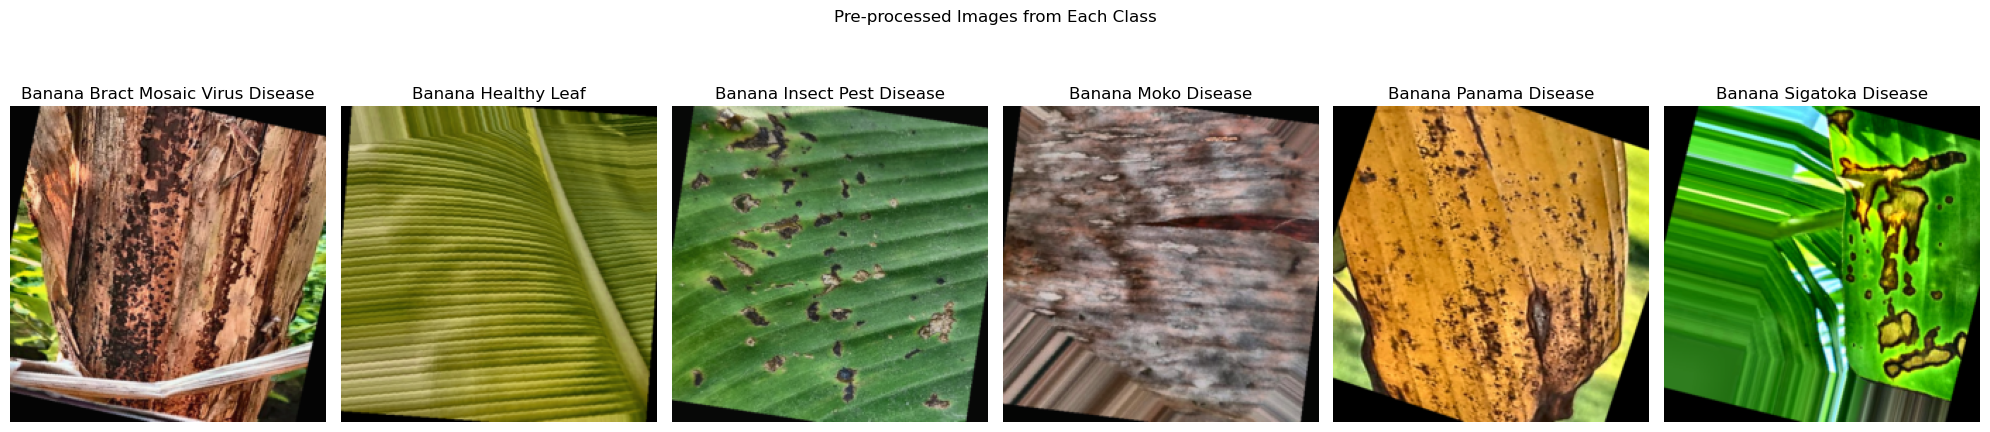

In [15]:
# Main Function
def main():
    # Define the path to the dataset folder containing the images
    dataset_path = r'dataset path (hardcoded)'

    # Initialize empty lists to store image paths and their corresponding labels
    image_paths, labels = [], []
    class_names = []

    # Loop through each class (folder) in the dataset path
    for label, class_name in enumerate(os.listdir(dataset_path)):
        # Construct the full path for each class folder
        class_folder = os.path.join(dataset_path, class_name)
        # Check if the folder is a directory
        if os.path.isdir(class_folder):
            # Append the class name to the class_names list
            class_names.append(class_name)
            # Loop through each image in the current class folder
            for image_name in os.listdir(class_folder):
                # Construct the full path for the image file
                image_path = os.path.join(class_folder, image_name)
                # Check if the image file has a valid extension (png, jpg, jpeg)
                if image_path.lower().endswith(('png', 'jpg', 'jpeg')):
                    # Add the image path and corresponding label to the lists
                    image_paths.append(image_path)
                    labels.append(label)

    # Split the image paths and labels into training and validation sets (80% training, 20% validation)
    train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

    # Create custom dataset instances for training and validation with corresponding transformations
    train_dataset = BananaDiseaseDataset(train_paths, train_labels, transform=train_transform)
    val_dataset = BananaDiseaseDataset(val_paths, val_labels, transform=val_transform)

    # Create data loaders for the training and validation datasets (batch size 32, shuffle training data)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Compute class weights to handle class imbalance by considering the frequency of each class in the training data
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    # Convert the computed class weights to a PyTorch tensor and move it to the appropriate device (CPU or GPU)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Define the number of classes (6 in this case)
    num_classes = 6  # Updated for 6 classes
    # Instantiate the CNN model for 6 classes and move it to the appropriate device
    model = CNNModel(num_classes).to(device)

    # Print a message indicating that the training process is starting
    print("Training the model...")
    # Start training the model using the train_with_honey_badger function
    train_with_honey_badger(model, train_loader, val_loader, class_weights, num_epochs=25, lr=1e-3)

    # Print a message indicating that pre-processed images will be displayed
    print("Displaying pre-processed images...")
    # Call the function to display the pre-processed images from the training dataset
    display_preprocessed_images(train_dataset, class_names)

# Entry point for the script: only run the main function if the script is executed directly
if __name__ == "__main__":
    main()


In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Average Confusion matrix 
confusion_matrix = np.array([
    [94.76, 0.00, 0.12, 1.16, 0.84, 0.12],
    [0.00, 150.96, 0.00, 0.00, 0.00, 0.04],
    [0.04, 0.36, 129.64, 0.00, 0.00, 2.96],
    [0.08, 0.04, 0.16, 68.48, 0.24, 0.00],
    [0.32, 0.12, 0.00, 0.24, 48.96, 0.36],
    [0.04, 0.08, 1.16, 0.32, 3.88, 147.52]
])

# Total number of instances per class (sum of each row)
total_instances = np.sum(confusion_matrix, axis=1)

# Accuracy per class (True Positive / Total instances for that class)
accuracy_per_class = np.diagonal(confusion_matrix) / total_instances

# Precision, Recall, F1 Score per class
precision_per_class = precision_score(confusion_matrix.argmax(axis=1), confusion_matrix.argmax(axis=1), average=None)
recall_per_class = recall_score(confusion_matrix.argmax(axis=1), confusion_matrix.argmax(axis=1), average=None)
f1_per_class = f1_score(confusion_matrix.argmax(axis=1), confusion_matrix.argmax(axis=1), average=None)

# Overall accuracy
overall_accuracy = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)

# Print performance measures per class
for i in range(len(total_instances)):
    print(f"Class {i+1}:")
    print(f"Accuracy: {accuracy_per_class[i]:.2f}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print(f"F1 Score: {f1_per_class[i]:.2f}")
    print()

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")


Class 1:
Accuracy: 0.98
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class 2:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class 3:
Accuracy: 0.97
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class 4:
Accuracy: 0.99
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class 5:
Accuracy: 0.98
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class 6:
Accuracy: 0.96
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Overall Accuracy: 0.98


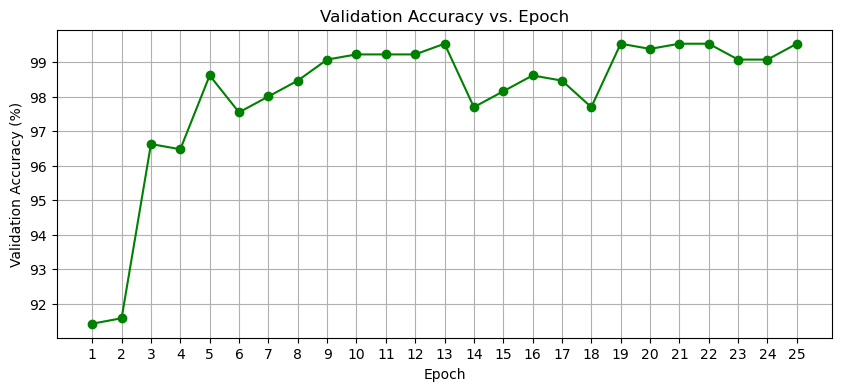

In [75]:
import matplotlib.pyplot as plt

# Assuming you have the following lists from your training output:
epochs = list(range(1, 26))  # Assuming 25 epochs
validation_accuracy = [
    91.42, 91.58, 96.63, 96.48, 98.62, 97.55, 98.01, 98.47, 99.08, 99.23,
    99.23, 99.23, 99.54, 97.70, 98.16, 98.62, 98.47, 97.70, 99.54, 99.39,
    99.54, 99.54, 99.08, 99.08, 99.54
]

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, validation_accuracy, marker='o', linestyle='-', color='g')
plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.xticks(epochs)  # Show all epoch numbers on x-axis
plt.show()

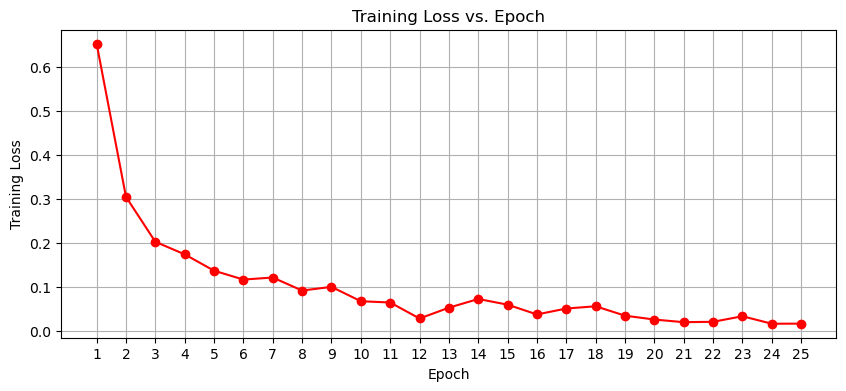

In [31]:
import matplotlib.pyplot as plt

# Assuming you have the following list from your training output:
epochs = list(range(1, 26))  # Assuming 25 epochs
train_loss = [
    0.6535, 0.3049, 0.2026, 0.1740, 0.1368, 0.1166, 0.1213, 0.0916, 0.1000, 0.0673,
    0.0644, 0.0280, 0.0526, 0.0724, 0.0595, 0.0372, 0.0507, 0.0558, 0.0344, 0.0256,
    0.0196, 0.0205, 0.0331, 0.0161, 0.0163
]

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='r')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.xticks(epochs)  # Show all epoch numbers on x-axis
plt.show()

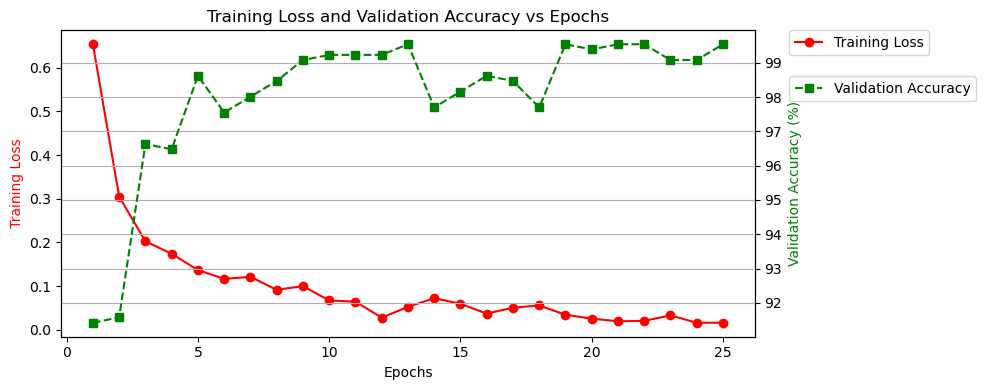

In [91]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 26))
train_loss = [
    0.6535, 0.3049, 0.2026, 0.1740, 0.1368, 0.1166, 0.1213, 0.0916, 0.1000, 0.0673,
    0.0644, 0.0280, 0.0526, 0.0724, 0.0595, 0.0372, 0.0507, 0.0558, 0.0344, 0.0256,
    0.0196, 0.0205, 0.0331, 0.0161, 0.0163
]
validation_accuracy = [
    91.42, 91.58, 96.63, 96.48, 98.62, 97.55, 98.01, 98.47, 99.08, 99.23,
    99.23, 99.23, 99.54, 97.70, 98.16, 98.62, 98.47, 97.70, 99.54, 99.39,
    99.54, 99.54, 99.08, 99.08, 99.54
]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot Loss (Primary y-axis)
ax1.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='red', label='Training Loss')

# Create a second y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, marker='s', linestyle='--', color='g', label='Validation Accuracy')

# Add title and labels
plt.title("Training Loss and Validation Accuracy vs Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color='red')  # Label for the first y-axis (Training Loss)
ax2.set_ylabel("Validation Accuracy (%)", color='g')  # Label for the second y-axis (Validation Accuracy)

# Add legends for both axes, placed outside the plot area
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85), borderaxespad=0.)

# Add grid
plt.grid(True)

# Adjust layout to fit everything
plt.tight_layout()

# Show plot
plt.show()


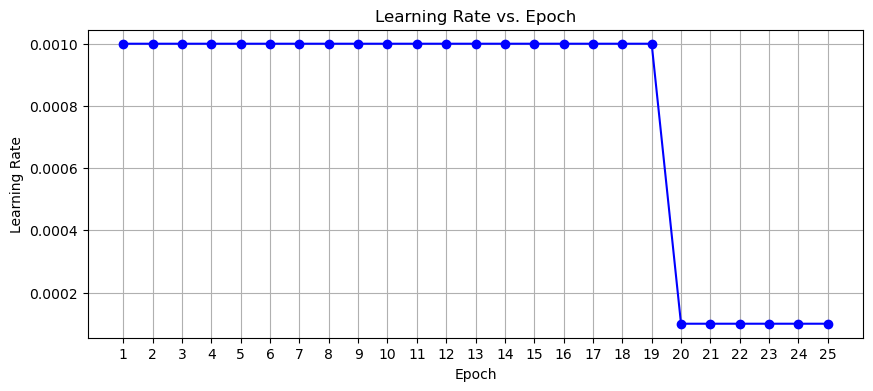

In [71]:
import matplotlib.pyplot as plt

# Assuming you have the following lists from your training output:
epochs = list(range(1, 26))  # Assuming 25 epochs
learning_rates = [
    0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
    0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001, 
    0.0001, 0.0001, 0.0001, 0.0001, 0.0001
]

# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
plt.title('Learning Rate vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.xticks(epochs)  # Show all epoch numbers on x-axis
plt.show()

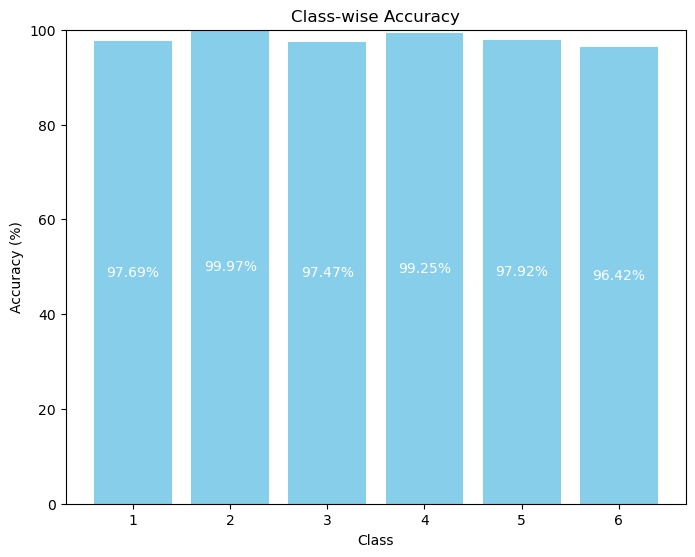

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Given confusion matrix
cm = np.array([
    [94.76, 0.00, 0.12, 1.16, 0.84, 0.12],
    [0.00, 150.96, 0.00, 0.00, 0.00, 0.04],
    [0.04, 0.36, 129.64, 0.00, 0.00, 2.96],
    [0.08, 0.04, 0.16, 68.48, 0.24, 0.00],
    [0.32, 0.12, 0.00, 0.24, 48.96, 0.36],
    [0.04, 0.08, 1.16, 0.32, 3.88, 147.52]
])

# Calculate accuracy per class
accuracy_per_class = np.diag(cm) / cm.sum(axis=1)

# Plotting class-wise accuracy
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(accuracy_per_class) + 1), accuracy_per_class * 100, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.xticks(range(1, len(accuracy_per_class) + 1))
plt.ylim(0, 100)

# Add text inside the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{yval:.2f}%', ha='center', va='center', fontsize=10, color='white')

# Adjust layout
plt.subplots_adjust(top=0.90)

# Show plot
plt.show()


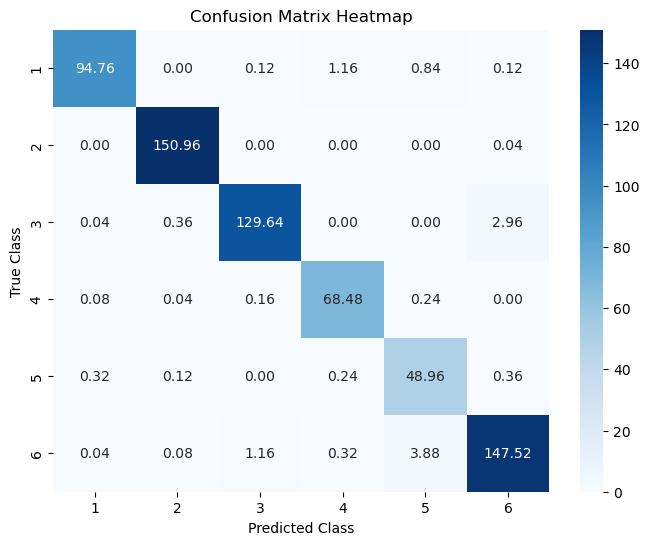

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Given confusion matrix
cm = np.array([
    [94.76, 0.00, 0.12, 1.16, 0.84, 0.12],
    [0.00, 150.96, 0.00, 0.00, 0.00, 0.04],
    [0.04, 0.36, 129.64, 0.00, 0.00, 2.96],
    [0.08, 0.04, 0.16, 68.48, 0.24, 0.00],
    [0.32, 0.12, 0.00, 0.24, 48.96, 0.36],
    [0.04, 0.08, 1.16, 0.32, 3.88, 147.52]
])

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
